In [1]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [20]:
'''Insert Code for GoEmotions classification'''

'Insert Code for GoEmotions classification'

In [41]:
llm_output = pd.read_csv('transcripts/LLM_outputs.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

llm_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimism', 'pessimism', 'vagueness',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['severity', 'responsiveness', 'evasiveness', 'allignment']

# add qna_labels to the llm_output
llm_output = pd.merge(llm_output, qna_analysis[["call_ID"] + qna_labels], on='call_ID', how='left')

In [42]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [48]:
'''COMPANY LEVEL'''

# Select the supporting features, nlp_lables, and RR from final_df
final_df = llm_output[['aggregated_RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + qna_labels]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

y_train, y_test = final_df['aggregated_RR'], final_df['aggregated_RR']
X_train, X_test = final_df.drop(columns=['aggregated_RR']), final_df.drop(columns=['aggregated_RR'])

                            OLS Regression Results                            
Dep. Variable:          aggregated_RR   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.263
Date:                Tue, 08 Oct 2024   Prob (F-statistic):              0.217
Time:                        14:45:37   Log-Likelihood:                -922.08
No. Observations:                 196   AIC:                             1882.
Df Residuals:                     177   BIC:                             1944.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   69.1845 

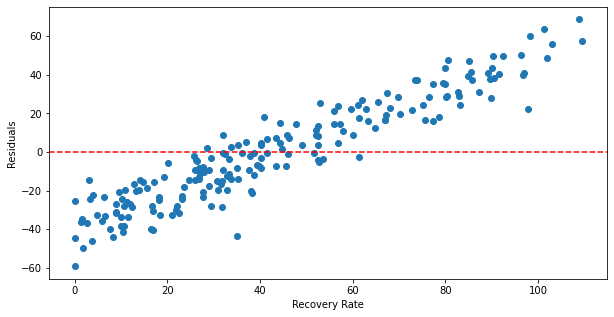

In [49]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [50]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                Features         VIF
0                  const  112.871811
5              pessimism    8.883500
1     negative_sentiment    7.815792
2     positive_sentiment    6.274935
4               optimism    6.198044
15              severity    4.600125
3            uncertainty    4.504881
18            allignment    4.424524
14         macroeconomic    4.053518
6              vagueness    3.225603
7     liquidity_position    2.955946
16        responsiveness    2.938011
9     operational_trends    2.930859
12   recovery_strategies    2.456949
10  industry_positioning    2.068380
13          legal_issues    1.997304
17           evasiveness    1.953643
11         asset_quality    1.891599
8   debt_leverage_stress    1.885133


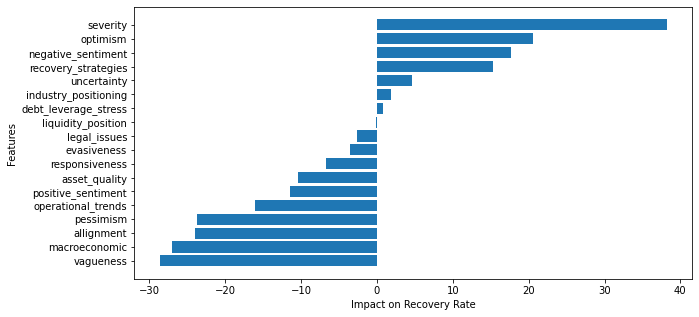

In [51]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Impact on Recovery Rate')
plt.ylabel('Features')
plt.show()

In [45]:
'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = llm_output[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + qna_labels]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     41.02
Date:                Tue, 08 Oct 2024   Prob (F-statistic):          1.40e-107
Time:                        14:45:22   Log-Likelihood:                -4624.6
No. Observations:                1051   AIC:                             9287.
Df Residuals:                    1032   BIC:                             9381.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  106.4495 

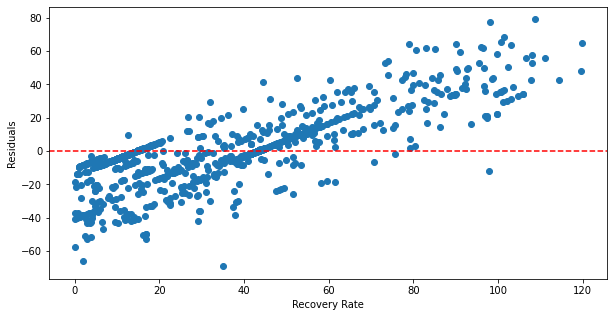

In [46]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

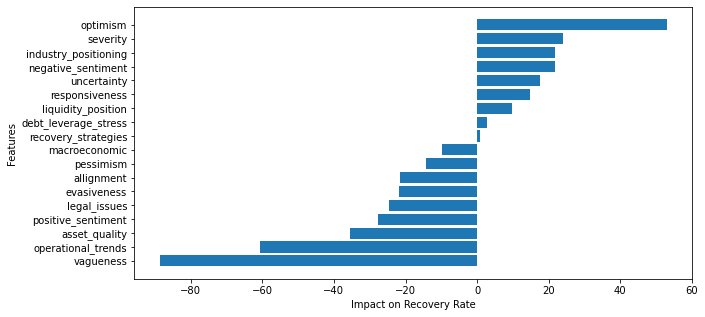

In [47]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Impact on Recovery Rate')
plt.ylabel('Features')
plt.show()